In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import torchvision
import time


In [2]:
data_dir = '/home/antpc/cough_detection/dataset/melspectograms/melspectrograms'

In [3]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True)

classes = ['cough', 'no_cough']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


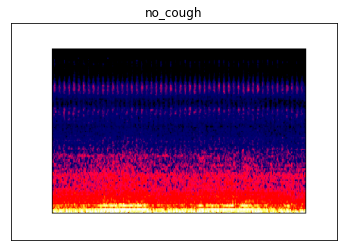

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1,1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [8]:
model = models.mobilenet_v2(pretrained=False)
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [10]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = True
    
n_inputs = model.classifier[1].in_features

last_layer = nn.Linear(n_inputs, len(classes))

model.classifier[1] = last_layer

print(model.classifier[1].out_features)
print(model)

criterion = torch.nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.000001)

model.to(device);

True
2
MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [11]:
epochs = 10
steps = 0
running_loss = 0
train_losses, test_losses,accuracy_acc = [], [],[]
start = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                    
                test_loss += batch_loss.item()
                    
                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracy_acc.append(accuracy/len(testloader))
                    
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        running_loss = 0
        model.train()
print("Time required: "+str(time.time() - start)+" seconds")

Epoch: 1/10..  Training Loss: 0.806..  Test Loss: 0.714..  Test Accuracy: 0.198
Epoch: 2/10..  Training Loss: 0.658..  Test Loss: 0.596..  Test Accuracy: 0.980
Epoch: 3/10..  Training Loss: 0.542..  Test Loss: 0.497..  Test Accuracy: 0.980
Epoch: 4/10..  Training Loss: 0.455..  Test Loss: 0.412..  Test Accuracy: 0.980
Epoch: 5/10..  Training Loss: 0.382..  Test Loss: 0.347..  Test Accuracy: 0.980
Epoch: 6/10..  Training Loss: 0.325..  Test Loss: 0.292..  Test Accuracy: 0.980
Epoch: 7/10..  Training Loss: 0.278..  Test Loss: 0.257..  Test Accuracy: 0.980
Epoch: 8/10..  Training Loss: 0.244..  Test Loss: 0.228..  Test Accuracy: 0.980
Epoch: 9/10..  Training Loss: 0.214..  Test Loss: 0.198..  Test Accuracy: 0.980
Epoch: 10/10..  Training Loss: 0.192..  Test Loss: 0.180..  Test Accuracy: 0.980
Time required: 140.1195571422577 seconds


In [15]:
PATH = '/home/antpc/cough_detection/codes/mobile_net.pt'
torch.save(model, PATH)
model.state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[-1.3864e-01,  1.7018e-01,  2.2226e-03],
                        [-2.3732e-02,  8.4904e-02,  5.0924e-02],
                        [-4.1185e-02,  1.3495e-01, -1.2692e-01]],
              
                       [[ 1.0479e-02, -1.0964e-01, -1.5846e-01],
                        [ 9.7111e-02,  8.4245e-02, -8.1806e-02],
                        [ 2.1205e-02,  1.0939e-01,  5.8169e-02]],
              
                       [[ 1.4986e-01, -1.2718e-01,  1.0957e-01],
                        [-6.2418e-02,  1.6021e-01, -4.1212e-02],
                        [-1.7122e-01,  1.8560e-02,  2.6879e-02]]],
              
              
                      [[[-1.0866e-01, -9.0251e-02, -2.9877e-03],
                        [-3.9181e-02, -1.0249e-02,  6.6570e-03],
                        [ 6.5912e-02,  5.3174e-02,  2.4365e-02]],
              
                       [[-1.1354e-04, -1.0323e-01,  2.4217e-02],
                        [ 3.9781e-02, 

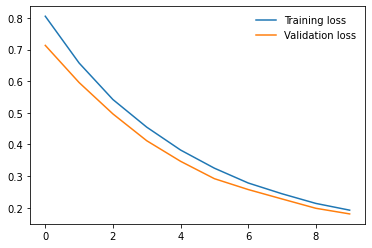

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

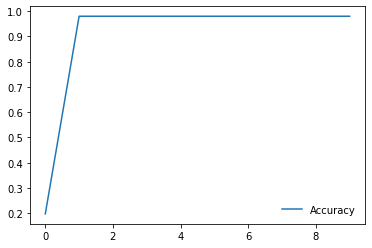

In [14]:
plt.plot(accuracy_acc, label='Accuracy')
plt.legend(frameon=False)


In [ ]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True)

dataiter = iter(testloader)
images, labels = dataiter.next()

images.numpy()
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    images = images.cuda()

# getting sample outputs
output = model(images)
print(output)
# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
print(preds_tensor)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
#remove single dimensional entries
print(preds)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1, 1, idx+1, xticks=[], yticks=[])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    print("Prediciton "+classes[preds])
    print("True class "+classes[labels])